In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory, Center
from openretina.optimization.objective import SingleNeuronObjective, SliceMeanReducer
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

In [2]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [3]:
from rgc_natstim_model.analyses.gradient import get_gradient_grid, equalize_channels

In [4]:
from rgc_natstim_model.analyses.mei_properties import get_temporal_contrast

# Import constants

In [5]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids

from rgc_natstim_model.constants.paths import base_directory

# Assemble paths

In [6]:
dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

file_name_template = r'2024-06-17_neuron_data_stim_c285329_responses_{}_wri.h5'
data_file_names = [file_name_template.format(dh[:7]) for dh in dataset_hashes]

data_file_names.pop()
data_file_names.append('2024-06-17_neuron_data_stim_41fc277_responses_5e62060_wri.h5')

movie_file_name = '2024-01-11_movies_dict_c285329.pkl'
flipped_movie_file_name = '2024-05-27_movies_dict_41fc277.pkl'

# Loading

In [7]:
with open(os.path.join(base_directory, 'data', 'mei', 'analysis', 'mei_analysis.pkl'), 'rb') as f:
    df = pickle.load(f)

In [8]:
with open(os.path.join(base_directory, 'data', 'mei', 'analysis', 'lin_mei_analysis_min.pkl'), 'rb') as f:
    lin_mei_analysis_df = pickle.load(f)

In [9]:
contrast_dict = {neuron_id: get_temporal_contrast(neuron_id, chans=[0, 1], 
                                                  df=lin_mei_analysis_df,
                                                  temp_key='time_kernel',
                                                  use_center_mask=True,
                                                  sing_key="singular_values")[1]
                 for neuron_id in lin_mei_analysis_df.index}
lin_mei_analysis_df.insert(0, "center_temp_cont_green", [contrast_dict[neuron_id]["green"] for neuron_id in lin_mei_analysis_df.index])
lin_mei_analysis_df.insert(0, "center_temp_cont_uv", [contrast_dict[neuron_id]["uv"] for neuron_id in lin_mei_analysis_df.index])

20210921_2_1_22_s_5
(36, 8)
20210921_2_1_75_s_5
(36, 8)
20210921_2_2_103_s_5
(36, 8)
20210921_2_3_76_s_5
(36, 8)
20210921_2_3_79_s_5
(36, 8)
20210921_2_6_75_s_5
(36, 8)
20210929_1_2_39_s_5
(36, 8)
20210929_2_1_13_s_5
(36, 8)
20210929_2_1_41_s_5
(36, 8)
20210929_2_1_90_s_5
(36, 8)
20210929_2_1_98_s_5
(36, 8)
20210929_2_2_72_s_5
(36, 8)
20210929_2_3_55_s_5
(36, 8)
20210929_2_4_32_s_5
(36, 8)
20201021_1_3_123_s_5
(36, 8)
20201021_1_4_126_s_5
(36, 8)
20201021_2_1_70_s_5
(36, 8)
20201022_2_1_15_s_5
(36, 8)
20201022_2_1_67_s_5
(36, 8)
20201022_2_3_119_s_5
(36, 8)
20201022_2_4_13_s_5
(36, 8)
20201030_1_1_100_s_5
(36, 8)
20201030_1_1_16_s_5
(36, 8)
20201030_1_2_25_s_5
(36, 8)
20201030_1_2_29_s_5
(36, 8)
20201030_1_3_54_s_5
(36, 8)
20201030_1_3_99_s_5
(36, 8)
20210910_2_2_70_s_5
(36, 8)
20210910_2_4_84_s_5
(36, 8)
20211130_2_2_36_s_5
(36, 8)
20200226_1_2_4_s_5
(36, 8)
20200303_1_2_91_s_5
(36, 8)
20200528_1_1_72_s_5
(36, 8)
20200529_1_1_15_s_5
(36, 8)
20200701_1_2_10_s_5
(36, 8)
20200701_2_3_108

In [10]:
lin_mei_analysis_df.shape

(36, 10)

# Get identifiers and mappings

In [11]:
neuron_ids = df[(df["celltype"]==28)].index


df_restr = df[(df["celltype"]==28)]

dataset_hashes = df[(df["celltype"]==28)]["dataset_hash"].to_numpy()


restr_nonlin = [dict(neuron_id=neuron_id, dataset_hash=dataset_hash,
              ensemble_hash=dh2eh[dataset_hash]) for neuron_id, dataset_hash in zip(neuron_ids, dataset_hashes)]
restr_lin = [dict(neuron_id=neuron_id, dataset_hash=dataset_hash,
              ensemble_hash=dh2eh_linear[dataset_hash]) for neuron_id, dataset_hash in zip(neuron_ids, dataset_hashes)]

neuron_id2dataset_hash = dict(zip(neuron_ids, dataset_hashes))

neuron_id2ensemble_hash = dict(zip(neuron_ids, [dh2eh_linear[neuron_id2dataset_hash[neuron_id]] 
                                               for neuron_id in neuron_ids]))

neuron_id2ensemble_hash_nonlin = dict(zip(neuron_ids, [dh2eh[neuron_id2dataset_hash[neuron_id]] 
                                               for neuron_id in neuron_ids]))

## movies

In [12]:
# load the movie 
movies_dict = pickle.load(open('/'.join([base_directory, 'data', 'movie', movie_file_name]), "rb"))

# load the movie file with the pre-flip-correction movie
movies_dict_flip = pickle.load(open('/'.join([base_directory, 'data', 'movie', flipped_movie_file_name]), "rb"))

### load all datasets

In [13]:
movie_data_dicts = {}
dataloaders_dict = {}
for dh, dfn in zip(list(dh2eh.keys()), data_file_names):
    data_path = os.path.join(base_directory, "data", 'base', dfn)
    responses = load_h5_into_dict(data_path)
    _movie_data_dict = make_final_responses(responses, response_type="natural") # upsampling
    if dh == '5e620609fc7b491aa5edb4a5d4cd7276':
        _dataloaders = natmov_dataloaders_v2(
        _movie_data_dict, movies_dict_flip, seed=1000
    )
    else:
        _dataloaders = natmov_dataloaders_v2(
            _movie_data_dict, movies_dict, seed=1000
        )
    movie_data_dicts.update({dh:_movie_data_dict})
    dataloaders_dict.update({dh:_dataloaders})

Loading HDF5 file contents:   0%|          | 0/385 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/11 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/11 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/175 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/5 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/5 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/140 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/4 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/4 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/700 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/20 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/20 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/210 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/6 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/6 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/945 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/27 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/27 [00:00<?, ?it/s]

In [14]:
# ToDo 
dh_2_session_ids = {k: list(v.keys()) for k, v in movie_data_dicts.items()}
session_ids_2_dhs = {_v: k for k, v in movie_data_dicts.items() for _v in list(v.keys())}
# remove empty session
session_ids_2_dhs.pop('session_1_ventral2_20200701')
dh_2_session_ids['5e620609fc7b491aa5edb4a5d4cd7276'].remove('session_1_ventral2_20200701')

dh_2_session_ids_renamed = {dh: ['_'.join(el.split('_')[1:]) for el in v] for dh, v in dh_2_session_ids.items()}

# Collect data in dataframe

In [15]:
full_df = convert_nested_dict_to_dataframe(movie_data_dicts)

# Calculate tuning across chromatic contrasts

In [16]:
reducer = SliceMeanReducer(1, 0, 20)

In [17]:
gradient_grid = {'CNN model': {'CNN MEI': {},
                                'LN MEI': {}},
                  'LN model': {'CNN MEI': {},
                                'LN MEI': {}}}
resp_grid = {'CNN model': {'CNN MEI': {},
                                'LN MEI': {}},
                  'LN model': {'CNN MEI': {},
                                'LN MEI': {}}}
norm_grid = {'CNN model': {'CNN MEI': {},
                                'LN MEI': {}},
                  'LN model': {'CNN MEI': {},
                                'LN MEI': {}}}

## CNN-type model responding to CNN-type model generated MEI

In [18]:
model_key = 'CNN model'

In [19]:
model_type = 'nonlinear'

In [20]:
stim_key = 'CNN MEI'

In [21]:
for dataset_hash in np.unique(dataset_hashes):
    ensemble_hash = dh2eh[dataset_hash]
    
    model_path = os.path.join(base_directory, "models", 
                              model_type, ensemble_hash)
    
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path);
    
    for session_id in dh_2_session_ids[dataset_hash]:
        temp_neuron_ids = full_df[full_df['session_id']==session_id]['neuron_id']
        curr_neuron_ids = [nid for nid in temp_neuron_ids if nid in df_restr.index]
        
        for neuron_id in curr_neuron_ids:
            nonlin_model_neuron_reduced = SingleNeuronObjective(
                ensemble_model, 
                neuron_idx=full_df['model_readout_idx'].loc[neuron_id],
                data_key='_'.join(session_id.split('_')[1:]),
                response_reducer=reducer
            )
            
            mei_stim = torch.unsqueeze(torch.Tensor(df_restr['mei'].loc[neuron_id]), 0) 
            scaled_mei = equalize_channels(mei_stim)
            
            _gradient_grid, _resp_grid, _norm_grid, green_contrast_values, uv_contrast_values = \
            get_gradient_grid(
                scaled_mei, nonlin_model_neuron_reduced, step_size=.2
            )
            
            gradient_grid[model_key][stim_key][neuron_id] = _gradient_grid
            resp_grid[model_key][stim_key][neuron_id] = _resp_grid
            norm_grid[model_key][stim_key][neuron_id] = _norm_grid
            
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()

Random seed 0 has been set.


/gpfs01/euler/User/lhoefling/GitHub/open-retina/openretina/hoefling_2024/models.py:815: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  return mask.T


Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 2000 has been set.
Ig

In [22]:
with open(os.path.join(base_directory, "data", 'response_gradient', f'{model_key}_{stim_key}.npz'), "wb") as f:
    np.savez(f, gradient_grid_dict=gradient_grid, 
             resp_grid_dict=resp_grid, 
             norm_grid_dict=norm_grid)
    

## LN-type model responding to CNN-type model generated MEI

In [23]:
model_key = 'LN model'

In [24]:
model_type = 'linear'

In [25]:
stim_key = 'CNN MEI'

In [26]:
for dataset_hash in np.unique(dataset_hashes):
    ensemble_hash = dh2eh_linear[dataset_hash]
    
    model_path = os.path.join(base_directory, "models", 
                              model_type, ensemble_hash)
    
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path);
    
    for session_id in dh_2_session_ids[dataset_hash]:
        temp_neuron_ids = full_df[full_df['session_id']==session_id]['neuron_id']
        curr_neuron_ids = [nid for nid in temp_neuron_ids if nid in df_restr.index]
        
        for neuron_id in curr_neuron_ids:
            lin_model_neuron_reduced = SingleNeuronObjective(
                ensemble_model, 
                neuron_idx=full_df['model_readout_idx'].loc[neuron_id],
                data_key='_'.join(session_id.split('_')[1:]),
                response_reducer=reducer
            )
            
            mei_stim = torch.unsqueeze(torch.Tensor(df_restr['mei'].loc[neuron_id]), 0) 
            scaled_mei = equalize_channels(mei_stim)
            
            _gradient_grid, _resp_grid, _norm_grid, green_contrast_values, uv_contrast_values = \
            get_gradient_grid(
                scaled_mei, lin_model_neuron_reduced, step_size=.2
            )
            
            gradient_grid[model_key][stim_key][neuron_id] = _gradient_grid
            resp_grid[model_key][stim_key][neuron_id] = _resp_grid
            norm_grid[model_key][stim_key][neuron_id] = _norm_grid
            
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()

Random seed 0 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Rando

In [27]:
with open(os.path.join(base_directory, "data", 'response_gradient', f'{model_key}_{stim_key}.npz'), "wb") as f:
    np.savez(f, gradient_grid_dict=gradient_grid, 
             resp_grid_dict=resp_grid, 
             norm_grid_dict=norm_grid)
    

# Plotting

In [28]:
from rgc_natstim_model.plotting.gradient import plot_vector_field_resp_iso, plot_resp_diff
from rgc_natstim_model.utils.plot import save_this

In [29]:
from matplotlib.ticker import FuncFormatter, FixedLocator

In [30]:
to_save = False

In [31]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [2, 2],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':1,
           'lines.linewidth':1,
           'lines.markeredgewidth': .5,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

In [32]:
example_cell_ids = ['20201021_1_4_126_s_5', '20210929_2_3_55_s_5']

In [33]:
plot_path = r'/gpfs01/euler/User/lhoefling/Plots/paper_figsgradient/paper/'

## CNN-type model responding to CNN-type model generated MEI

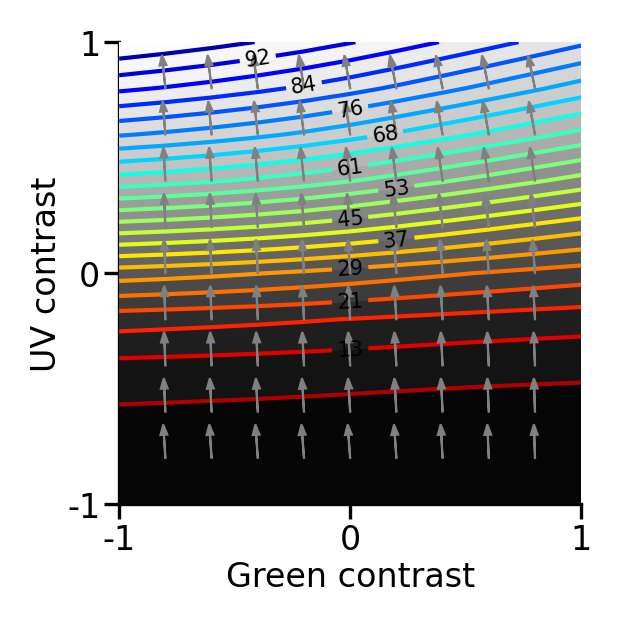

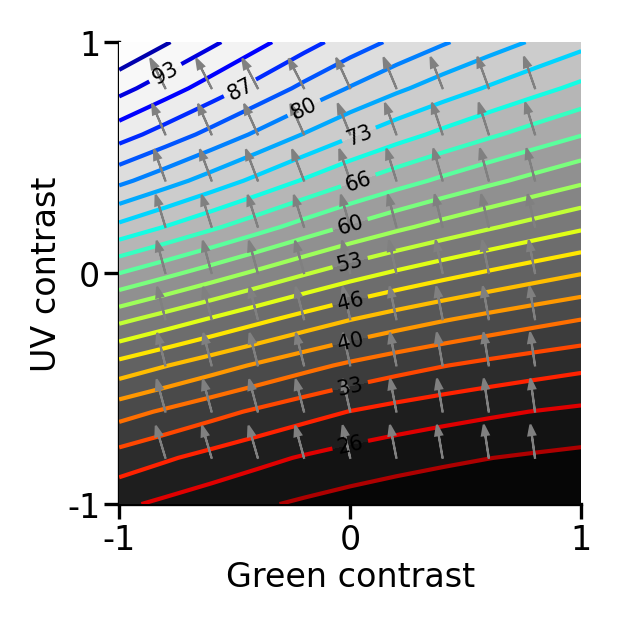

In [34]:
model_key = 'CNN model'
stim_key = 'CNN MEI'

for neuron_id in example_cell_ids:
    x = np.arange(-1, 1.2, .2)
    plot_vector_field_resp_iso(x, x, 
                               norm_grid[model_key][stim_key], 
                               gradient_grid[model_key][stim_key], 
                               resp_grid[model_key][stim_key],
                              neuron_id=neuron_id, normalize_response=True, cmap="Greys_r", rc_dict=rc_dict)
    if to_save:
        save_this(plot_path, '_'.join([neuron_id,'model', model_key.split(' ')[0], 'stim', stim_key.split(' ')[0], ]), 
                  pdf=True, svg=False)
        plt.close()

## LN-type model responding to CNN-type model generated MEI

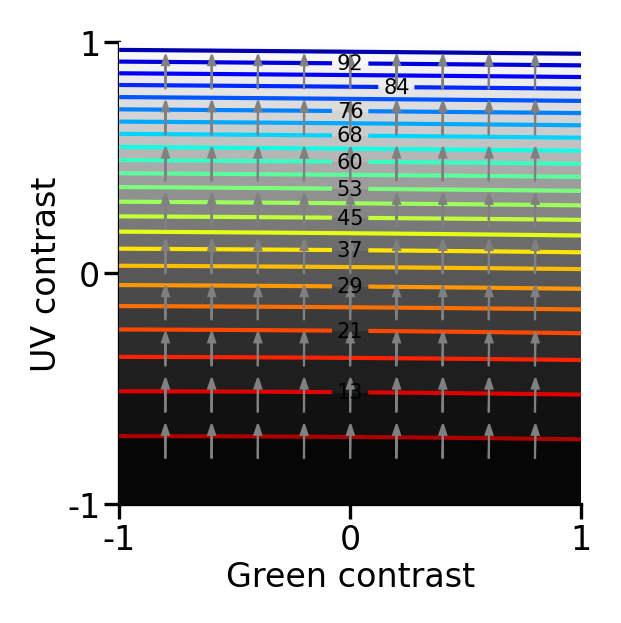

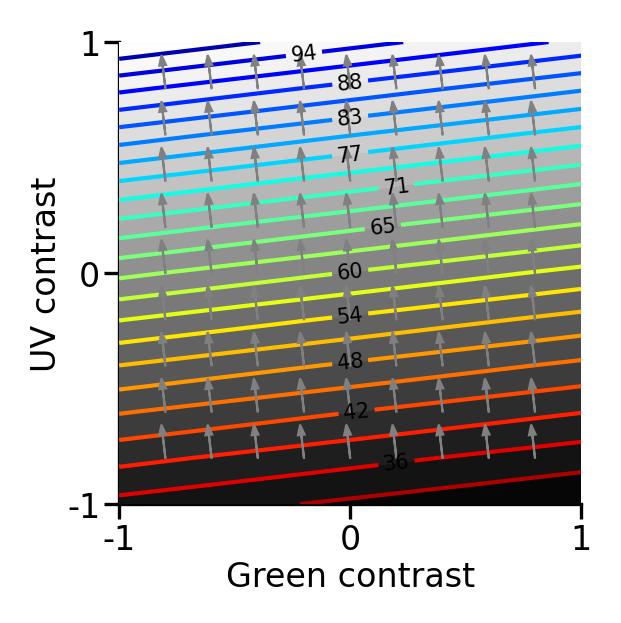

In [35]:
model_key = 'LN model'
stim_key = 'CNN MEI'

for neuron_id in example_cell_ids:
    x = np.arange(-1, 1.2, .2)
    plot_vector_field_resp_iso(x, x, 
                               norm_grid[model_key][stim_key], 
                               gradient_grid[model_key][stim_key], 
                               resp_grid[model_key][stim_key],
                              neuron_id=neuron_id, normalize_response=True, cmap="Greys_r", rc_dict=rc_dict)
    if to_save:
        save_this(plot_path, '_'.join([neuron_id,'model', model_key.split(' ')[0], 'stim', stim_key.split(' ')[0], ]), 
                  pdf=True, svg=False)
        plt.close()

## plot response difference

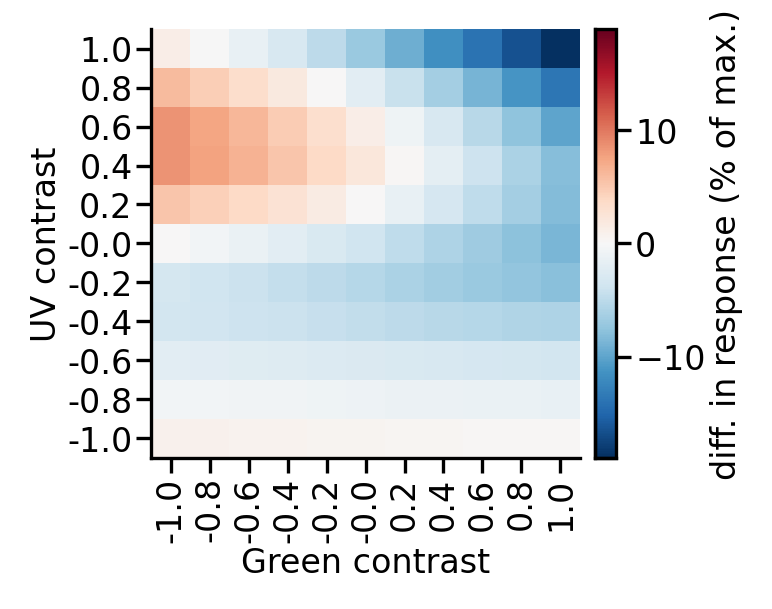

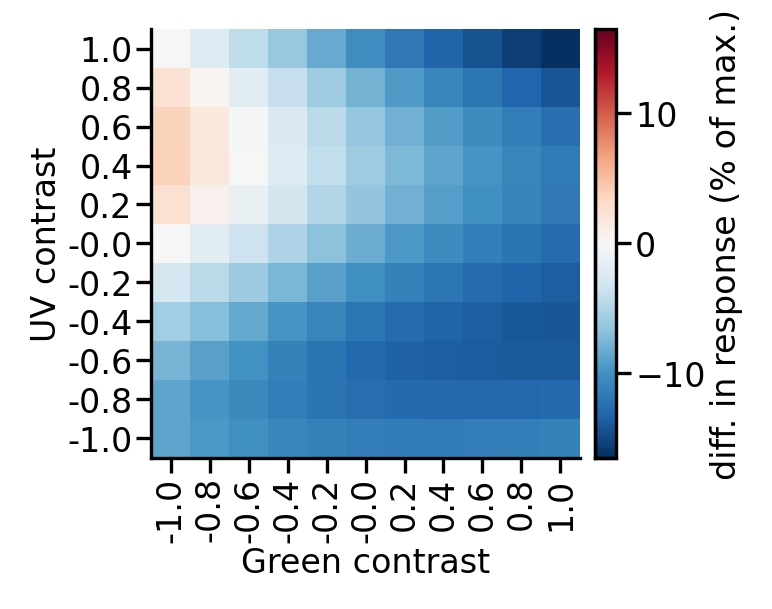

In [36]:
for neuron_id in example_cell_ids:
    plot_resp_diff(resp_grid['CNN model']['CNN MEI'],
                   resp_grid['LN model']['CNN MEI'],
                   neuron_id, x, 
                  rc_dict=rc_dict);
    if to_save:
        save_this(plot_path, '_'.join([neuron_id,'resp_diff']), 
                  pdf=True, svg=False)

# Visualize stimuli

In [37]:
from rgc_natstim_model.plotting.mei_properties import space_time_plot

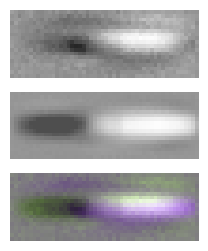

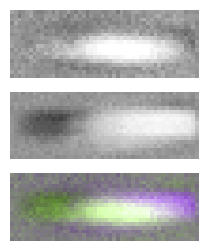

In [38]:
for neuron_id in example_cell_ids:
    mei_stim = mei_stim = torch.unsqueeze(torch.Tensor(df_restr['mei'].loc[neuron_id]), 0) 
    scaled_mei = equalize_channels(mei_stim, flip_green=True).cpu().numpy().squeeze()
    space_time_plot(scaled_mei)

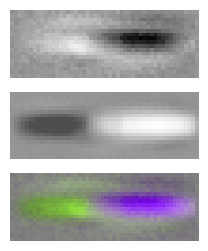

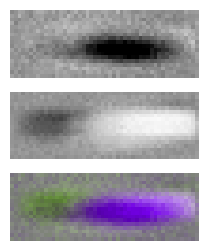

In [39]:
for neuron_id in example_cell_ids:
    mei_stim = mei_stim = torch.unsqueeze(torch.Tensor(df_restr['mei'].loc[neuron_id]), 0) 
    scaled_mei = equalize_channels(mei_stim, flip_green=False).cpu().numpy().squeeze()
    space_time_plot(scaled_mei)

# plot MEI distribution

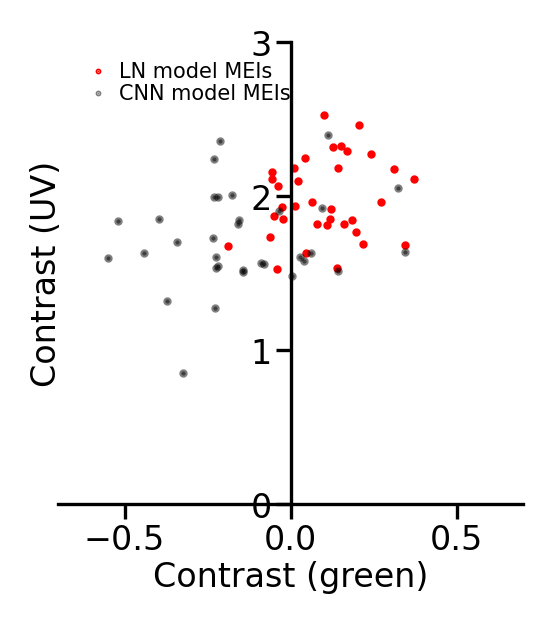

In [40]:
with mpl.rc_context(rc_dict):
    plt.scatter([lin_mei_analysis_df["center_temp_cont_green"].loc[neuron_id] for neuron_id in neuron_ids], 
                [lin_mei_analysis_df["center_temp_cont_uv"].loc[neuron_id] for neuron_id in neuron_ids],
                color="r", label='LN model MEIs')

    plt.scatter([df["center_temp_cont_green"].loc[neuron_id] for neuron_id in neuron_ids], 
                [df["center_temp_cont_uv"].loc[neuron_id] for neuron_id in neuron_ids],
                color="k", alpha=.5, label='CNN model MEIs')
    plt.legend(loc='upper left', fontsize=5)
    sns.despine()
    g = plt.gca()
    g.set_xlim(-.7, .7)
    g.set_ylim(0, 3)
    g.axes.spines["bottom"].set_position("zero")
    g.axes.spines["left"].set_position("zero")
    g.set_xlabel('Contrast (green)')
    g.set_ylabel('Contrast (UV)', labelpad=45)